# This code does 3 things
1) Balances dataset
2) Cross validation based on inter-patient method
3) Train on simple classifiers

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn.utils import resample
from sklearn.model_selection import LeavePGroupsOut
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn import tree
from scipy.stats import skew
from collections import Counter

In [3]:
# Helper functions
def get_sleep_info_per_patient(df):
    pids = df['pid'].unique()
    info = []
    for pid in pids:
    #for pid, i in zip(pids, range(1)): # debugging
        pid_df = df.loc[df['pid'] == pid]
        W = (pid_df.loc[df['sleep_stage'] == 0]).shape[0]
        S1 = (pid_df.loc[df['sleep_stage'] == 1]).shape[0]
        S2 = (pid_df.loc[df['sleep_stage'] == 2]).shape[0]
        SWS = (pid_df.loc[df['sleep_stage'] == 3]).shape[0]
        R = (pid_df.loc[df['sleep_stage'] == 4]).shape[0]
        assert((W + S1 + S2 + SWS + R) == pid_df.shape[0])
        info.append([pid, W, S1, S2, SWS, R])

    return info

def remove_patients_with_missing_stages(df, info):
    bad_patients = [p[0] for p in info if 0 in p[1:None]]
    for pid in bad_patients:
        df = df.drop(df[df.pid == pid].index)
    return df

def remove_extra_patients(df, num_to_remove):
    num_to_remove *= -1
    bad_patients = df['pid'].value_counts().index.tolist()[num_to_remove:None]
    for pid in bad_patients:
        df = df.drop(df[df.pid == pid].index)
    return df

def resample_df(df, info):
    threshold = math.ceil(np.mean([np.mean([epoch[1:None] for epoch in info])]))
    df_new = pd.DataFrame()
    pids = df['pid'].unique()
    for pid in pids:
        df_pid = df.loc[df['pid'] == pid]
        for sleep_stage in range(0, 5):
            df_epoch = df_pid.loc[df_pid['sleep_stage'] == sleep_stage]
            if df_epoch.shape[0] > threshold:
                df_epoch = resample(df_epoch, n_samples = threshold, replace = False, random_state = 42)
            else:
                df_epoch = resample(df_epoch, n_samples = threshold, replace = True,  random_state = 42)
            #print(df_epoch)
            df_new = pd.concat([df_new, df_epoch])
    num_classes = 5
    assert(df_new['sleep_stage'].nunique() == num_classes)    # 5 output classes
    a = [x for x in df_new['sleep_stage'].value_counts()]
    b = threshold * len(pids)
    assert(a == b for a in a)  # Ensure each patient in resampled dataset has equal distribution of sleep stage classes

    return df_new

def transform(X, Y):
    #print(np.min(X))
    assert(np.min(X) > 0)

    X0 = X
    X1 = np.log10(X0)
    X0 = (X0-np.mean(X0, axis=0))/np.std(X0, axis=0)
    X1 = (X1-np.mean(X1, axis=0))/np.std(X1, axis=0)

    Nepochs, Nfeatures = X.shape
    print(X.shape)

    # reduce skew
    X1_skew = skew(X1, axis=0)
    X0_skew = skew(X0, axis=0)
    skew_delta = np.abs(X0_skew)-np.abs(X1_skew)
    skew_delta = skew_delta
    #indices where we have non-beneficial log transform
    bad_log_i = np.where(skew_delta < 0)
    print(bad_log_i)

    # # plot effect of log transform
    # plt.figure()
    # plt.scatter(np.arange(Nfeatures), skew_delta)
    # plt.axhline(0, c="black", linestyle="--")
    # plt.title("Skewness improvement with log transform")
    # plt.show()

    # i = np.argmax(np.abs(X1_skew))
    # plt.figure()
    # _ = plt.hist(X1[:,i], bins=100, label="Log transform")
    # _ = plt.hist(X0[:,i], bins=100, label="Original")
    # plt.legend()
    # plt.title(f"Histogram of worst skewness after log transform - X{i}")
    # plt.show()

    # i = np.argmin(np.abs(X1_skew))
    # plt.figure()
    # _ = plt.hist(X1[:,i], bins=100, label="Log transform")
    # _ = plt.hist(X0[:,i], bins=100, label="Original")
    # plt.legend()
    # plt.title(f"Histogram of best skewness after log transform - X{i}")
    # plt.show()

    # ignore log transform where it worsens skew
    X1[:,bad_log_i] = X0[:,bad_log_i]
    Y1 = Y

    return X1, Y1

# Does the following:
# 1) Obtain number of epochs per sleep stage per patient
# 2) Filter out patients with a missing sleep stage (79 -> 68)
# 3) Reduce last 2 patients (68 -> 66) so 6-Fold CV can be performed later
# 4) Resample based on average number of epochs per sleep stage averaged across all patients. This comes out to be 247 epochs per sleep stage per patient.
def rebalance_df(df):
    train_size = 44
    valid_size = 11
    test_size = 11
    total_size = train_size + valid_size + test_size # = 66

    info = get_sleep_info_per_patient(df)
    df = remove_patients_with_missing_stages(df, info)
    assert(df['pid'].nunique() >= total_size)
    df = remove_extra_patients(df, df['pid'].nunique() - total_size)

    info = get_sleep_info_per_patient(df)
    df = resample_df(df, info)
    return df

def df_to_array(df):
    X = []
    Y = []
    groups = []
    pids = df['pid'].unique()
    pid_to_group = {pid: x % 6 for (pid, x) in zip(pids, range(66))}

    for row in df.to_numpy():
        X.append(row[1:-1])
        Y.append(int(row[-1]))
        groups.append(pid_to_group[row[0]])

    X = np.asarray(X)
    Y = np.asarray(Y)       
    groups = np.asarray(groups)
    return X, Y, groups


In [4]:
# (Change this if needed) load csv file with epoch features
data_csv = 'E:/HDD documents/University/comp9417/comp9417-project-21t2/data/subband_data.csv'
df = pd.read_csv(data_csv)
df = df.dropna()    # there should not be any nan values anyway

df = rebalance_df(df)
X, Y, groups = df_to_array(df)
X1, Y1 = transform(X, Y)
# %%
# split into training and testing
lpgo = LeavePGroupsOut(n_groups = 1)
lpgo.get_n_splits(X1, Y1, groups)


(81510, 22)
(array([12], dtype=int64),)


6

0.6773794626426205
0.6640412219359588
0.6824880382775119
0.6494663231505337
0.6745528156054472
0.6703717335296283
0.6753183658446816
0.6674273095325727
0.6765255796834744
0.6703717335296283
0.6778652926021347
0.6549135075450865


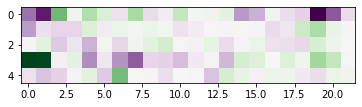

In [5]:
for train_valid_index, test_index in lpgo.split(X1, Y1, groups):    # returns generators
    X_train_valid = X1[train_valid_index]
    y_train_valid = Y1[train_valid_index]
    X_test = X1[test_index]
    y_test = Y1[test_index]
    # print(f'X_train {X[train_valid_index].shape} y_train_valid {y[train_valid_index].shape} X_test {X[test_index].shape} y_test {y[test_index].shape}')

    # Put classifiers and run training, validation, and testing below here within this loop

    clf = LogisticRegression(max_iter=1000)
    clf = clf.fit(X_train_valid, y_train_valid)

    y_pred = clf.predict(X_train_valid)
    train_acc = np.mean(y_pred == y_train_valid)
    y_pred = clf.predict(X_test)
    test_acc = np.mean(y_pred == y_test)

    print(train_acc)
    print(test_acc) # approx 60-70% with inter-patient

    plt.imshow(clf.coef_, cmap="PRGn")
    #plt.colorbar()

## Old code for classifiers below

In [ ]:
pid = 0
mask = (df['pid'] == pid)
x = X[mask]
y = Y[mask]

# Plot our true and predicted hypnogram
len_slice = 100
n_slice = 7
i = np.arange(0, len_slice) + len_slice*n_slice
#i = np.arange(0, y.shape[0])
epoch_time = 30
t = i*(epoch_time/3600) # hours

y_true = y
y_pred =  clf.predict(x)
print(np.mean(y_true == y_pred))
print(np.mean(y_true[i] == y_pred[i]))

fig = plt.figure(figsize=(20,10))
plt.step(t, y_true[i], label="ytrue")
plt.step(t, y_pred[i], linestyle="--", label="ypred")
_ = plt.yticks(np.unique(y))
plt.grid(True)
plt.legend()



clf = SVC()
clf.fit(Xtrain, Ytrain)

ypred = clf.predict(Xtrain)
train_acc = np.mean(ypred == Ytrain)
ypred = clf.predict(Xtest)
test_acc = np.mean(ypred == Ytest)
print(train_acc)
print(test_acc)





pid = 0
mask = (df['pid'] == pid)
x = X[mask]
y = Y[mask]

# Plot our true and predicted hypnogram
len_slice = 100
n_slice = 7
i = np.arange(0, len_slice) + len_slice*n_slice
#i = np.arange(0, y.shape[0])
epoch_time = 30
t = i*(epoch_time/3600) # hours

y_true = y
y_pred =  clf.predict(x)
print(np.mean(y_true == y_pred))
print(np.mean(y_true[i] == y_pred[i]))

fig = plt.figure(figsize=(20,10))
plt.step(t, y_true[i], label="ytrue")
plt.step(t, y_pred[i], linestyle="--", label="ypred")
_ = plt.yticks(np.unique(y))
plt.grid(True)
plt.legend()